In [2]:
# 授权绑定Google Drive 
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools 
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null 
!apt-get update -qq 2>&1 > /dev/null 
!apt-get -y install -qq google-drive-ocamlfuse fuse 
from google.colab import auth 
auth.authenticate_user() 
from oauth2client.client import GoogleCredentials 
creds = GoogleCredentials.get_application_default() 
import getpass 
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL 
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

E: Package 'python-software-properties' has no installation candidate
Selecting previously unselected package google-drive-ocamlfuse.
(Reading database ... 110856 files and directories currently installed.)
Preparing to unpack .../google-drive-ocamlfuse_0.7.1-0ubuntu3~ubuntu18.04.1_amd64.deb ...
Unpacking google-drive-ocamlfuse (0.7.1-0ubuntu3~ubuntu18.04.1) ...
Setting up google-drive-ocamlfuse (0.7.1-0ubuntu3~ubuntu18.04.1) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
··········
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=ht

In [3]:
# 指定Google Drive云端硬盘的根目录，名为drive
!mkdir -p drive
!google-drive-ocamlfuse drive

# 指定当前的工作目录
import os

# 此处为google drive中的文件路径,drive为之前指定的工作根目录，要加上
os.chdir("drive/ECE4950_pattern/HW1/Assignment1_release") 


# 查看文件目录，是否包含所需的文件
!ls

Assignment1_Coding-Skeleton.ipynb  krkopt_data.txt  tic-tac-toe.data
assignment-1.pdf		   krkopt_info.txt
chess.png			   tic_tac.jpg


# Machine Learning for Games

It has been widely publicized that machine learning has achieved great success in game playing during recent years, including ancient games like [GO](https://en.wikipedia.org/wiki/Go_(game) to modern computer games like [Starcraft](https://starcraft2.com/en-us/). For news, see:

[The awful frustration of a teenage Go champion playing Google’s AlphaGo](https://qz.com/993147/the-awful-frustration-of-a-teenage-go-champion-playing-googles-alphago/)

[AI defeated humans at StarCraft II. Here’s why it matters.](https://www.wired.com/story/deepmind-beats-pros-starcraft-another-triumph-bots/)


We don't have enough background for understanding these complicated algorithms yet. In this assignment, we are going to see how decision trees can help understand some simple games including TIC-TAC-TOE and chess(King-Rook vs. King).

Make sure you have installed [Pandas](https://pandas.pydata.org/), [numpy](http://www.numpy.org/), [graphviz](https://www.graphviz.org/) and [Scikit Learn](https://scikit-learn.org/) before running the script.

```bash
    conda install pandas numpy graphviz scikit-learn
```
or

```bash
    pip3 install pandas numpy graphviz scikit-learn
```

You may find the following links useful:

http://scikit-learn.org/stable/modules/tree.html and
http://scikitlearn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html#sklearn.tree.DecisionTreeClassifier

## 1. Tic-Tac-Toe Endgame Classification
For introduction and rules of Tic-Tac-Toe, see [Wiki page](https://en.wikipedia.org/wiki/Tic-tac-toe). 

<img src="tic_tac.jpg" width="400">

We will use Tic-Tac-Toe Endgame Data Set from UCI machine learning repository. (See introduction [here](https://archive.ics.uci.edu/ml/datasets/Tic-Tac-Toe+Endgame)). This database encodes the complete set of possible board configurations at the end of tic-tac-toe games, where "x" is assumed to have played first. The target concept is "win for x" (i.e., true when "x" has one of 8 possible ways to create a "three-in-a-row"). 

The dataset has 9 attributes, each indicating the status of each squre. ('x' if "x" is placed, 'o' is "o" is placed and 'b' if blank). Examples of the dataset can be seen here:

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.utils import shuffle
tic_toc = pd.read_csv('./tic-tac-toe.data', header=None) #read dataset
tic_toc.columns = ['top_left_sqr', 'top_middle_sqr', 'top_right_sqr',
             'mid_left_sqr', 'mid_mid_sqr', 'mid_right_sqr', 
             'btm_left_sqr', 'btm_mid_sqr', 'btm_right_sqr',
             'class']
tic_toc = shuffle(tic_toc, random_state = 0)
tic_toc.head(10)
# positive means x wins

,top_left_sqr,top_middle_sqr,top_right_sqr,mid_left_sqr,mid_mid_sqr,mid_right_sqr,btm_left_sqr,btm_mid_sqr,btm_right_sqr,class
879,b,x,x,x,x,o,o,o,o,negative
496,b,x,o,x,x,x,o,o,b,positive
14,x,x,x,o,x,o,o,o,x,positive
546,b,o,x,o,b,x,x,o,x,positive
55,x,x,x,b,o,x,b,o,o,positive
785,o,x,o,b,o,x,o,x,x,negative
202,x,o,b,x,b,o,x,x,o,positive
566,b,o,o,x,x,x,b,x,o,positive
940,b,b,o,b,x,o,x,x,o,negative
299,o,x,x,o,x,o,x,x,o,positive


### Post-processing
To get these features and labels fit into learning models, we need to convert them into integer or boolean variables. For features with $k$ possible values, a common trick is one-hot encoding (dummy variables). Suppose feature $X$ can take $k$ possible values, we encode it into a $k$-dimensional boolean vector where there is a one at location $i$ if $X = 1$ and zeros elsewhere. Suppose $X$ can take $5$ possible values and $X = 3$. Then

$$ Enc(X) = (0, 0, 1, 0, 0) $$

We do this for each feature with $k = 3$ and convert labels to $\{0, 1\}$. Note that for one hot encoding, we can always drop the first dimension since if all others are zeros, we know it has to be one.

Next we randomly pick $70\%$ of the data to  be our training set and the remaining for testing.

After this, each training example has $18$ features. Training set looks like the following:

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

#set all positive class to 1 and negative class to 0;
tic_toc.loc[tic_toc['class'] == 'positive', 'class'] = 1
tic_toc.loc[tic_toc['class'] == 'negative', 'class'] = 0
#use one-hot encoding to recreate the dataset X which excludes the class column.
X = pd.get_dummies(tic_toc.iloc[:, :-1], drop_first=True)
y = tic_toc['class'].astype('int')
#devide the dataset into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state = 0)
X.head()

,top_left_sqr_o,top_left_sqr_x,top_middle_sqr_o,top_middle_sqr_x,top_right_sqr_o,top_right_sqr_x,mid_left_sqr_o,mid_left_sqr_x,mid_mid_sqr_o,mid_mid_sqr_x,mid_right_sqr_o,mid_right_sqr_x,btm_left_sqr_o,btm_left_sqr_x,btm_mid_sqr_o,btm_mid_sqr_x,btm_right_sqr_o,btm_right_sqr_x
879,0,0,0,1,0,1,0,1,0,1,1,0,1,0,1,0,1,0
496,0,0,0,1,1,0,0,1,0,1,0,1,1,0,1,0,0,0
14,0,1,0,1,0,1,1,0,0,1,1,0,1,0,1,0,0,1
546,0,0,1,0,0,1,1,0,0,0,0,1,0,1,1,0,0,1
55,0,1,0,1,0,1,0,0,1,0,0,1,0,0,1,0,1,0


### Problem 1
Using information gain as you splitting criterion, set the maximum depth from 1 to 12. Plot the training and testing error with respect to each maximum depth. Justify your plot.

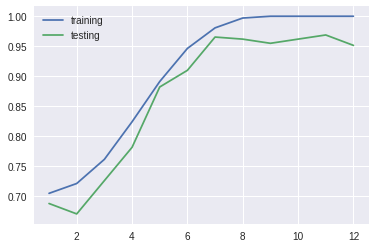

In [6]:
Err_Train = np.zeros(12)
Err_Test = np.zeros(12)
indices = range(1,13)

#==================Your code ===================
for max_depth in indices:
    clf = DecisionTreeClassifier(criterion='entropy',max_depth=max_depth)
    his = clf.fit(X_train,y_train)
    y_pre_test = clf.predict(X_test)
    y_pre_train = clf.predict(X_train)
    # score = clf.score(X_test, y_test)
    Err_Test[max_depth-1] = accuracy_score(y_pre_test, y_test)
    Err_Train[max_depth-1] = accuracy_score(y_pre_train, y_train)
    #print (err_train, err_test)
#==============================================
plt.plot(indices,Err_Train, label = "training")
plt.plot(indices,Err_Test, label = "testing")
plt.legend()

### Problem 2
Using GINI impurity as you splitting criterion, set the maximum depth from 1 to 11. Plot the training and testing error with respect to each maximum depth. Is it the same with information gain?

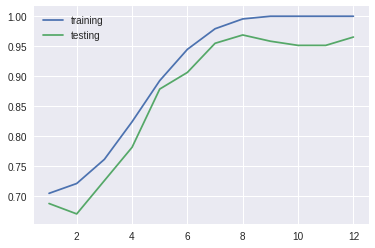

In [7]:
Err_Train = np.zeros(12)
Err_Test = np.zeros(12)
indices = range(1,13)
#==================Your code ===================
for max_depth in indices:
    model_dtc = DecisionTreeClassifier(criterion='gini',max_depth=max_depth)
    his = model_dtc.fit(X_train,y_train)
    y_pre_test = model_dtc.predict(X_test)
    y_pre_train = model_dtc.predict(X_train)
    Err_Test[max_depth-1] = accuracy_score(y_pre_test, y_test)
    Err_Train[max_depth-1] = accuracy_score(y_pre_train, y_train)
#==============================================

plt.plot(indices,Err_Train, label = "training")
plt.plot(indices,Err_Test, label = "testing")
plt.legend()

# Problem 3
Pick any tree you have learned above. Let "model_dtc" be the model you have created using scikit-learn. The following script will print the tree into file 'TIC-TOC-TOE.pdf'. What is the root node? Explain whether it coincides with your intuition.

In [8]:
from sklearn import tree
import graphviz 
dot_data = tree.export_graphviz(model_dtc, out_file=None, 
                    feature_names = X.columns,
                    class_names= 'win',  
                    filled=True, rounded=True,  
                    special_characters=True)  
graph = graphviz.Source(dot_data) 
graph.render("TIC-TOC-TOE") 

'TIC-TOC-TOE.pdf'

## 2. Chess(King-Rook vs. King) Endgame Classification
For introduction and rules of Chess, see [Wiki page](https://en.wikipedia.org/wiki/Chess). 
<img src="chess.png" width="400">

We will use Chess(King-Rook vs. King) Data Set from UCI machine learning repository. (See introduction [here](https://archive.ics.uci.edu/ml/datasets/Chess+(King-Rook+vs.+King)). This database has 28056 possible instances of chess endgame situations where the white has a king and a rook and the black has only a king. The goal is to determine what is the minimum depth for the white to win.

The dataset has 6 attributes. Each of them can take 8 values, listed as following:

1. White King file (column a - h) 
2. White King rank (row 1 - 8) 
3. White Rook file 
4. White Rook rank 
5. Black King file 
6. Black King rank 

And the label is the least number of steps that the white must use to win. (draw if more than 16). The following is how the data set looks like.

In [21]:
chess = pd.read_csv('./krkopt_data.txt', header=None)
chess.columns = ['wkf', 'wkr', 'wrf', 'wrr', 'bkf', 'bkr', 'class']
chess = shuffle(chess, random_state = 0)
chess.head(10)

,wkf,wkr,wrf,wrr,bkf,bkr,class
22363,b,2,d,1,g,7,fourteen
18474,c,2,a,6,e,6,thirteen
24609,d,1,d,2,f,4,fourteen
3668,d,2,h,1,a,2,five
6969,c,1,f,5,g,1,nine
4007,d,1,b,4,h,1,six
16585,d,3,h,1,c,6,twelve
5441,c,2,b,4,g,1,eight
6712,b,1,e,3,g,1,nine
27543,d,1,f,4,e,6,fifteen


Next we convert these values into boolean features using the same one-hot encoding trick we described for TIC-TAC-TOE game. Deleting symmetric features (the dataset only has white kings in the bottom-left corner) for the white king and drop the first for the others, we get a data set with $36$ boolean features. 

Next we randomly pick $70\%$ of the data to  be our training set and the remaining for testing. Training set looks like the following:

In [22]:
from sklearn.preprocessing import LabelEncoder

d_wkf = pd.get_dummies(chess['wkf'], prefix='wkf')
d_wkr = pd.get_dummies(chess['wkr'], prefix='wkr')
d_wrf = pd.get_dummies(chess['wrf'], prefix='wrf', drop_first=True)
d_wrr = pd.get_dummies(chess['wrr'], prefix='wrr', drop_first=True)
d_bkf = pd.get_dummies(chess['bkf'], prefix='bkf', drop_first=True)
d_bkr = pd.get_dummies(chess['bkr'], prefix='bkr', drop_first=True)
chess_new = pd.concat([d_wkf, d_wkr, d_wrf, d_wrr, d_bkf, d_bkr, chess['class']], axis=1)
X = chess_new.iloc[:, :-1]
y = chess_new['class']
le = LabelEncoder()
y = le.fit_transform(y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
X_train.head(10)

,wkf_a,wkf_b,wkf_c,wkf_d,wkr_1,wkr_2,wkr_3,wkr_4,wrf_b,wrf_c,...,bkf_f,bkf_g,bkf_h,bkr_2,bkr_3,bkr_4,bkr_5,bkr_6,bkr_7,bkr_8
3409,0,0,0,1,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
18073,0,0,1,0,1,0,0,0,0,0,...,0,0,1,0,0,0,0,0,1,0
3544,0,0,0,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8869,0,0,1,0,0,1,0,0,1,0,...,0,1,0,0,1,0,0,0,0,0
11300,0,0,1,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
10037,0,0,0,1,0,0,1,0,0,0,...,0,0,1,0,0,0,0,0,0,1
18156,0,0,1,0,1,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
17803,0,1,0,0,0,1,0,0,0,0,...,0,0,1,0,0,0,0,1,0,0
13751,0,1,0,0,0,1,0,0,0,0,...,0,0,1,0,0,0,1,0,0,0
3240,0,0,0,1,1,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0


### Problem 4 
Using information gain as you splitting criterion, set the maximum depth from 20 to 35. Plot the training and testing error with respect to each maximum depth. When is the maximum training accuracy achieved? When is the maximum testing accuracy achieved? Explain this phenomenon.

Err_Train:
[0.89693976 0.92357045 0.94796069 0.96440756 0.97642446 0.98538622
 0.99154743 0.99536636 0.9978614  0.99938897 0.99984724 1.
 1.         1.         1.         1.        ]
Err_Test:
[0.53356303 0.53261257 0.53926577 0.54116669 0.54021623 0.53867174
 0.54294879 0.54484971 0.54057265 0.54009742 0.53902816 0.53962219
 0.54282999 0.54057265 0.53962219 0.54271118]


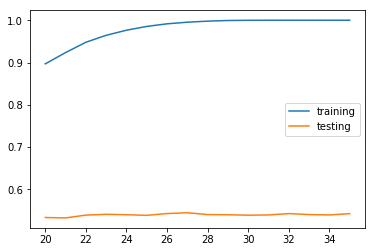

In [30]:
start = 20
end = 36
indices = range(start,end)
Err_Train = np.zeros(end - start)
Err_Test = np.zeros(end - start)
#==================Your code ===================
count = 0
for max_depth in indices:
    clf = DecisionTreeClassifier(criterion='entropy',max_depth=max_depth)
    his = clf.fit(X_train,y_train)
    y_pre_test = clf.predict(X_test)
    y_pre_train = clf.predict(X_train)
    # score = clf.score(X_test, y_test)
    Err_Test[count] = accuracy_score(y_pre_test, y_test)
    Err_Train[count] = accuracy_score(y_pre_train, y_train)
    count = count+1

print("Err_Train:")
print(Err_Train)
print("Err_Test:")
print(Err_Test)
#==============================================


plt.plot(indices,Err_Train, label = "training")
plt.plot(indices,Err_Test, label = "testing")
plt.legend()

### Answer 4
1. When maximum depth is 32, the maximum training accuracy is achieved. 
2. The accuracy of test set is fluctuation, which means the tendacy of the accuracy go up and down and it is unstable. And when the max_depth is 28, it achieves the maximum test accuracy. 
3. This is because the model is too complex with too many layers of tree so it leads to overfitting. The noise of data also is considered by this model. 




### Problem 5
Let's take a step further towards real AI applications. For the same game set-up, suppose you have a perfect decision tree which can tell you the minimum number of moves the white need to win. Given any instance, can you tell us which move is the optimal move for the white?